In [188]:
# A necessary evil
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
import astropy.units as u
from astropy.time import Time
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from datetime import datetime, timezone, timedelta

from Utilities import TimeRange
from Io import fgs_is_tracking_direct, fgs_use_angular_rate_direct, fgs_active_pecs_direct, load_stars_table_direct
from Fgs import FgsStarTrackingInterval, FgsStarTrackingIntervalStatistics, fgs_star_tracking_intervals_to_json_file, fgs_star_tracking_intervals_from_json_file, fgs_star_tracking_interval_statistics_to_json_file, fgs_star_tracking_interval_statistics_from_json_file

In [190]:
all = TimeRange(start=datetime(2023, 8, 3, tzinfo=timezone.utc), end=datetime.utcnow())
pvrestart = TimeRange(start=datetime(2023, 9, 6, tzinfo=timezone.utc), end=datetime.utcnow())
original = TimeRange(start=datetime(2023, 9, 1, tzinfo=timezone.utc), end=datetime(2023, 9, 6, tzinfo=timezone.utc))
last24 = TimeRange(start=datetime.utcnow() - timedelta(days=1), end=datetime.utcnow())
fgstestperiod1 = TimeRange(start=datetime(2023, 9, 18, tzinfo=timezone.utc), end=datetime.utcnow())
pretestperiod = TimeRange(start=datetime(2023, 9, 15, tzinfo=timezone.utc), end=datetime(2023, 9, 18, tzinfo=timezone.utc))

# Pick your times
time_range = fgstestperiod1

### Create stars table

In [191]:
stars_table = load_stars_table_direct(time_range)
print(stars_table.colnames)
print(stars_table)

['POSIX', 'UTC_STRING', '1_STAR_STATUS', '2_STAR_STATUS', '3_STAR_STATUS', '4_STAR_STATUS', '5_STAR_STATUS', '6_STAR_STATUS', '7_STAR_STATUS', '8_STAR_STATUS', '9_STAR_STATUS', '10_STAR_STATUS', '11_STAR_STATUS', '12_STAR_STATUS', '13_STAR_STATUS', '14_STAR_STATUS', '15_STAR_STATUS', '16_STAR_STATUS', '17_STAR_STATUS', '18_STAR_STATUS', '19_STAR_STATUS', '20_STAR_STATUS', '1_STAR_INDEX', '2_STAR_INDEX', '3_STAR_INDEX', '4_STAR_INDEX', '5_STAR_INDEX', '6_STAR_INDEX', '7_STAR_INDEX', '8_STAR_INDEX', '9_STAR_INDEX', '10_STAR_INDEX', '11_STAR_INDEX', '12_STAR_INDEX', '13_STAR_INDEX', '14_STAR_INDEX', '15_STAR_INDEX', '16_STAR_INDEX', '17_STAR_INDEX', '18_STAR_INDEX', '19_STAR_INDEX', '20_STAR_INDEX', '1_STAR_X', '2_STAR_X', '3_STAR_X', '4_STAR_X', '5_STAR_X', '6_STAR_X', '7_STAR_X', '8_STAR_X', '9_STAR_X', '10_STAR_X', '11_STAR_X', '12_STAR_X', '13_STAR_X', '14_STAR_X', '15_STAR_X', '16_STAR_X', '17_STAR_X', '18_STAR_X', '19_STAR_X', '20_STAR_X', '1_STAR_Y', '2_STAR_Y', '3_STAR_Y', '4_STAR

### FGS mode: tracking phase windows identification

In [192]:
tdb_fgs_mode, fgs_is_tracking_interval_min_indices, fgs_is_tracking_interval_max_indices = fgs_is_tracking_direct(time_range)

### FGS mode: angular rate windows identification

In [193]:
tdb_fgs_use_angular_rate, fgs_use_angular_rate_interval_min_indices, fgs_use_angular_rate_interval_max_indices = fgs_use_angular_rate_direct(time_range)

### Interval selection

In [194]:
TIME_MINUS_INFINITY = Time('1900-01-01T00:00:00', scale='tdb')
TIME_PLUS_INFINITY = Time('2100-01-01T00:00:00', scale='tdb')
MIN_TIME_DIFFERENCE = 50 * u.s  # Interval duration is 2s larger

# Create mask. Initially, all values are good
tdb_stars = Time(stars_table['UTC_STRING'], scale='tdb')
tdb_stars_valid = np.full_like(tdb_stars, True, dtype=bool)
print(f'Initial number of star data valid values: {np.count_nonzero(tdb_stars_valid)}')

# Mask values when FGS is not tracking
for time_min, time_max in zip([TIME_MINUS_INFINITY, *tdb_fgs_mode[fgs_is_tracking_interval_max_indices]],
                            [*tdb_fgs_mode[fgs_is_tracking_interval_min_indices], TIME_PLUS_INFINITY]):
    tdb_stars_valid[(tdb_stars > time_min) & (tdb_stars < time_max)] = False
print(f'Current number of star data valid values after tracking filter: {np.count_nonzero(tdb_stars_valid)}')

# Mask values when angular rate is not used
for time_min, time_max in zip([TIME_MINUS_INFINITY, *tdb_fgs_use_angular_rate[fgs_use_angular_rate_interval_max_indices]],
                            [*tdb_fgs_use_angular_rate[fgs_use_angular_rate_interval_min_indices], TIME_PLUS_INFINITY]):
    tdb_stars_valid[(tdb_stars > time_min) & (tdb_stars < time_max)] = False
print(f'Current number of star data valid values after angular rate filter: {np.count_nonzero(tdb_stars_valid)}')

# Find good data intervals
tdb_stars_indices = np.arange(len(tdb_stars_valid))
tdb_stars_labels_array, tdb_stars_n_labels = ndimage.label(tdb_stars_valid)
tdb_stars_interval_min_indices, tdb_stars_interval_max_indices, _, _ = \
    ndimage.extrema(tdb_stars_indices, tdb_stars_labels_array,
                    index=np.arange(1, tdb_stars_n_labels + 1))

# Filter by minimum time difference
long_intervals = [tdb_stars[tdb_stars_interval_max_index] -  tdb_stars[tdb_stars_interval_min_index] >= MIN_TIME_DIFFERENCE
                for tdb_stars_interval_min_index, tdb_stars_interval_max_index
                in zip(tdb_stars_interval_min_indices, tdb_stars_interval_max_indices)]
tdb_stars_long_interval_min_indices = tdb_stars_interval_min_indices[long_intervals]
tdb_stars_long_interval_max_indices = tdb_stars_interval_max_indices[long_intervals]
print(f'Intervals longer than the minimum threshold {MIN_TIME_DIFFERENCE}: {np.count_nonzero(long_intervals)}')

Initial number of star data valid values: 72650
Current number of star data valid values after tracking filter: 71237
Current number of star data valid values after angular rate filter: 70569
Intervals longer than the minimum threshold 50.0 s: 385


### Active PEC determination

In [195]:
tdb_fgs_active_pec, fgs_active_pec1, fgs_active_pec2 = fgs_active_pecs_direct(time_range)

tdb_stars_long_interval_pec1 = [
    fgs_active_pec1[(tdb_fgs_active_pec >= tdb_min) & (tdb_fgs_active_pec <= tdb_max)][0]
    for tdb_min, tdb_max in zip(
    tdb_stars[tdb_stars_long_interval_min_indices], tdb_stars[tdb_stars_long_interval_max_indices])]
tdb_stars_long_interval_pec2 = [
    fgs_active_pec2[(tdb_fgs_active_pec >= tdb_min) & (tdb_fgs_active_pec <= tdb_max)][0]
    for tdb_min, tdb_max in zip(
    tdb_stars[tdb_stars_long_interval_min_indices], tdb_stars[tdb_stars_long_interval_max_indices])]


### Rearrange data into intervals

In [196]:
intervals = [
    FgsStarTrackingInterval.from_webmust_table(stars_table[interval_min_index:interval_max_index+1], pec1, pec2)
    for pec1, pec2, interval_min_index, interval_max_index in zip(
        tdb_stars_long_interval_pec1, tdb_stars_long_interval_pec2,
        tdb_stars_long_interval_min_indices, tdb_stars_long_interval_max_indices)
]

### JSON de- and serialization of intervals

In [197]:
fgs_star_tracking_intervals_to_json_file(intervals, 'fgs_star_tracking_intervals.json')
intervals2 = fgs_star_tracking_intervals_from_json_file('fgs_star_tracking_intervals.json')

### Compute statistics

In [198]:
interval_statistics = [
    FgsStarTrackingIntervalStatistics.from_fgs_star_tracking_interval(interval)
    for interval in intervals]

/opt/miniconda/envs/euclid-tools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/opt/miniconda/envs/euclid-tools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### JSON de- and serialization of interval statistics

In [199]:
# JSON de- and serialization
fgs_star_tracking_interval_statistics_to_json_file(interval_statistics, 'fgstestperiod1.json')

### Basic plots

In [200]:
x_median_std_pec1 = [stats.x_median_std_pec1 for stats in interval_statistics]
x_median_std_pec2 = [stats.x_median_std_pec2 for stats in interval_statistics]
y_median_std_pec1 = [stats.y_median_std_pec1 for stats in interval_statistics]
y_median_std_pec2 = [stats.y_median_std_pec2 for stats in interval_statistics]
x_median_drift_pec1 = [abs(stats.x_median_drift_pec1) for stats in interval_statistics]
x_median_drift_pec2 = [abs(stats.x_median_drift_pec2) for stats in interval_statistics]
y_median_drift_pec1 = [abs(stats.y_median_drift_pec1) for stats in interval_statistics]
y_median_drift_pec2 = [abs(stats.y_median_drift_pec2) for stats in interval_statistics]
duration_s = [(stats.time_end - stats.time_start).to(u.s).value for stats in interval_statistics]
n_stars = [len(stats.x_medians_pec1) + len(stats.x_medians_pec2) for stats in interval_statistics]

### std PEC1 x PEC2

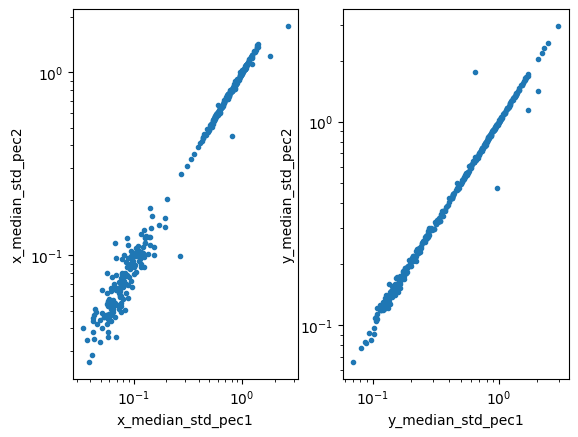

In [201]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_median_std_pec1, x_median_std_pec2, '.')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('x_median_std_pec1')
axs[0].set_ylabel('x_median_std_pec2')
axs[1].plot(y_median_std_pec1, y_median_std_pec2, '.')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('y_median_std_pec1')
axs[1].set_ylabel('y_median_std_pec2')
plt.show()

### drift PEC1 x PEC2

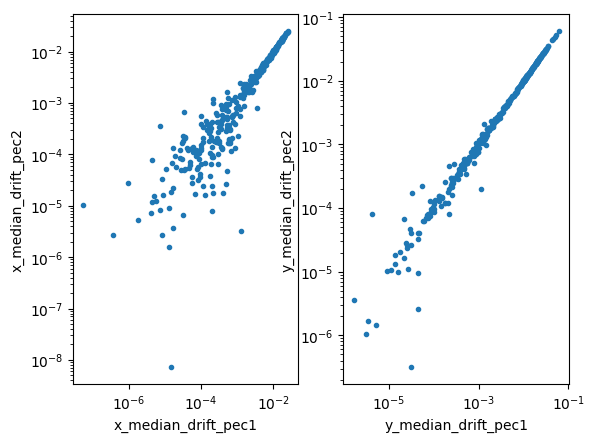

In [202]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_median_drift_pec1, x_median_drift_pec2, '.')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('x_median_drift_pec1')
axs[0].set_ylabel('x_median_drift_pec2')
axs[1].plot(y_median_drift_pec1, y_median_drift_pec2, '.')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('y_median_drift_pec1')
axs[1].set_ylabel('y_median_drift_pec2')
plt.show()

### std x drift

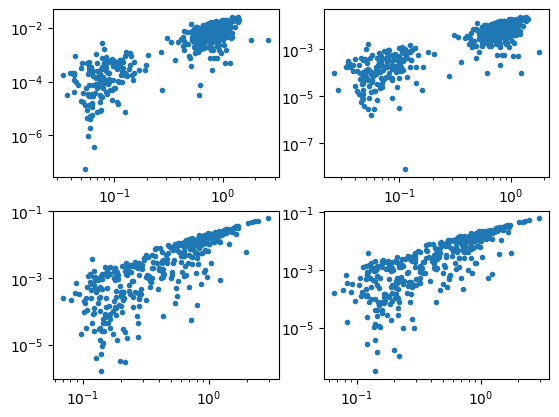

In [203]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(x_median_std_pec1, x_median_drift_pec1, '.')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].plot(x_median_std_pec2, x_median_drift_pec2, '.')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[1,0].plot(y_median_std_pec1, y_median_drift_pec1, '.')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].plot(y_median_std_pec2, y_median_drift_pec2, '.')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
plt.show()

### duration x drift

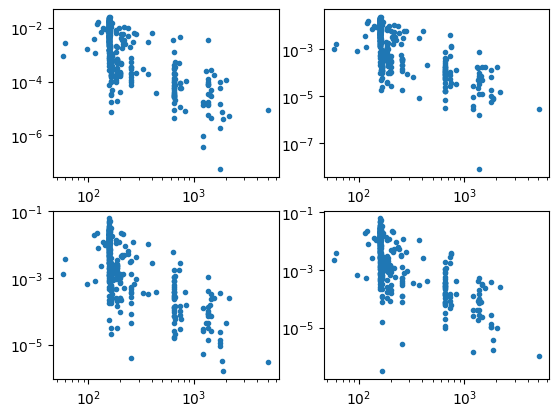

In [204]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(duration_s, x_median_drift_pec1, '.')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].plot(duration_s, x_median_drift_pec2, '.')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[1,0].plot(duration_s, y_median_drift_pec1, '.')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].plot(duration_s, y_median_drift_pec2, '.')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
plt.show()

### duration x std

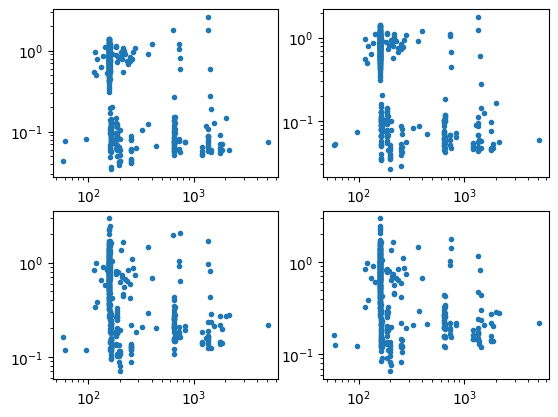

In [205]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(duration_s, x_median_std_pec1, '.')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].plot(duration_s, x_median_std_pec2, '.')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[1,0].plot(duration_s, y_median_std_pec1, '.')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].plot(duration_s, y_median_std_pec2, '.')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
plt.show()

### n_stars x std

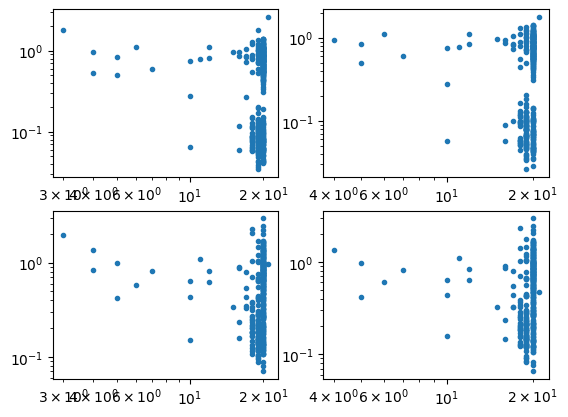

In [206]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(n_stars, x_median_std_pec1, '.')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].plot(n_stars, x_median_std_pec2, '.')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[1,0].plot(n_stars, y_median_std_pec1, '.')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].plot(n_stars, y_median_std_pec2, '.')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
plt.show()

### n_stars x drift

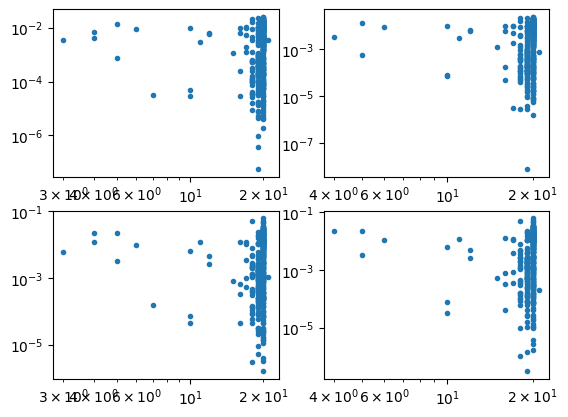

In [207]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(n_stars, x_median_drift_pec1, '.')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].plot(n_stars, x_median_drift_pec2, '.')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[1,0].plot(n_stars, y_median_drift_pec1, '.')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].plot(n_stars, y_median_drift_pec2, '.')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
plt.show()

### durations

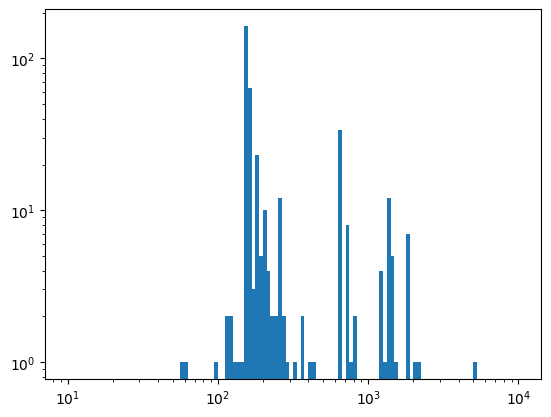

In [208]:
plt.hist(duration_s, bins=np.geomspace(10,10000, 121))
plt.xscale('log')
plt.yscale('log')
plt.show()